In [1]:
from typing import List, Dict, Tuple, Callable, Union
import os
import gc
import traceback
import warnings
from pdb import set_trace

import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix
)
!pip3 install -U ucimlrepo 
from ucimlrepo import fetch_ucirepo
from seaborn import pairplot
from sklearn.preprocessing import LabelEncoder
bean = fetch_ucirepo(id=602)
en = LabelEncoder()
bean.data.targets_nums = en.fit_transform(np.ravel(bean.data.targets))

In [2]:
#This is the code I used to generate the data visualization 
#bean_df = pd.concat([bean.data.features, bean.data.targets], axis = 1)
# bean_df = bean_df.rename(columns={bean.data.targets.columns[0]: 'targets'})
# plot = pairplot(bean_df, hue = 'targets')
# plot.savefig("pairplot.png")

In [3]:
def train_test_split(
    X: np.ndarray, 
    y: np.ndarray,
    train_size: float, 
    random_state: int
):
    rng = np.random.RandomState(random_state)
    random_idx = rng.permutation(len(X))
    X = X[random_idx]
    y = y[random_idx]
    split_idx = int(len(X) * train_size)
    X_trn, X_tst, y_trn, y_tst = X[:split_idx], X[split_idx:], y[:split_idx], y[split_idx:]
    return X_trn, X_tst, y_trn, y_tst

In [4]:
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

In [5]:
def get_preprocessed_data(drop_features: List[str] = None) -> Tuple[np.ndarray]:
    X = bean.data.features.copy()
    y = bean.data.targets_nums.copy()
    if drop_features is not None:
        X = X.drop(columns = drop_features)

    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X.to_numpy(), y)
    
    return X_trn, y_trn.reshape(-1, 1), X_vld, y_vld.reshape(-1, 1), X_tst, y_tst.reshape(-1, 1)

In [6]:
def euclidean_distance(x: np.ndarray, Y: np.ndarray) -> np.ndarray:
    assert len(Y.shape) == 2, f"y is a 1D vector, expected 2D row vector or matrix"
    return np.sqrt(np.sum(((x - Y) * (x - Y)).T, axis = 0))

In [7]:
def accuracy(y: np.ndarray, y_hat: np.ndarray) -> float:
    y =  y.reshape(-1,)
    y_hat = y_hat.reshape(-1,)
    are_same = y_hat == y
    total_correct = np.sum(are_same)
    total_samples = len(y)
    print(f"Accuracy ratio: {total_correct}/{total_samples}")
    return float(total_correct / total_samples)

In [8]:
class KNearestNeighbors():
    def __init__(self, k: int, distance_measure: Callable):
        self.k = k
        self.distance_measure = distance_measure
        self.X: np.ndarray = None
        self.y: np.ndarray = None
        
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self.X = np.asarray(X)
        self.y = np.asarray(y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        y_hats: list = []
        for sample in X:
            distance = self.distance_measure(sample, self.X)
            nearest_indicies = np.argsort(distance)[:self.k]
            nearest_labels = self.y[nearest_indicies]
            label_counts = np.bincount(nearest_labels)
            y_hats.append(np.argmax(label_counts))
        return np.array(y_hats)

In [9]:
def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_names: Dict[int, str] = None
) -> pd.DataFrame:
    y =  y.flatten()
    y_hat = y_hat.flatten()
    
    cfm = confusion_matrix(y_true=y, y_pred=y_hat)    
    
    labels = np.sort(np.unique(y))
    if class_names is not None:
        classes = []
        for l in labels:
            class_name = class_names.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    sns.heatmap(cfm_df, annot=True)
    plt.show()
    return cfm_df

In [10]:
def compute_log_priors(y: np.ndarray) -> np.ndarray:
    unique_labels, counts = np.unique(y, return_counts = True)
    return np.log( counts / len(y))

In [11]:
def log_gaussian(
    x: np.ndarray, 
    mu: Union[np.ndarray, float], 
    sigma: Union[np.ndarray, float],
) -> np.ndarray:
    return -0.5 * np.log(2 * np.pi) - np.log(np.asarray(sigma)) - 0.5 * ((x - (np.asarray(mu))) ** 2) / (np.asarray(sigma) ** 2)

In [12]:
def compute_parameters(
    X: np.ndarray, 
    y: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    means = []
    stds = []
    K = np.unique(y)
    y = y.flatten()
    for k in K:
        mean_k = np.mean(X[(y == k)], axis = 0)
        means.append(mean_k)
        std_k = np.std(X[(y == k)], axis = 0)
        stds.append(std_k)
    means = np.array(means)
    stds = np.array(stds)
    
    return means, stds

In [13]:
def compute_log_likelihoods(X, means, stds, verbose=True):
    log_likelihoods = []
    for mu, sigma in zip(means, stds):
        class_log_likelihood = []
        for x in X:
            log_likelihood_sample = 0
            for xi, mui, sigmai in zip(x, mu, sigma):
                if sigmai == 0:
                    log_likelihood_sample += -np.inf
                else:
                    log_likelihood_sample += -0.5 * np.log(2 * np.pi * sigmai**2) - (xi - mui)**2 / (2 * sigmai**2)
            class_log_likelihood.append(log_likelihood_sample)
        log_likelihoods.append(class_log_likelihood)
    return np.array(log_likelihoods).T

In [14]:
class GaussianNaiveBayes():
    def __init__(self):
        self.log_priors = None
        self.means = None
        self.stds = None
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> object:
        self.log_priors = compute_log_priors(y)
        self.means, self.stds = compute_parameters(X, y)
        return self
        
    def predict(self, X: np.ndarray):
        log_likelihoods = compute_log_likelihoods(X, self.means, self.stds)
        log_posteriors = log_likelihoods + self.log_priors
        return np.argmax(log_posteriors, axis=1)

Accuracy ratio: 6239/8710
Training accuracy: 0.716303


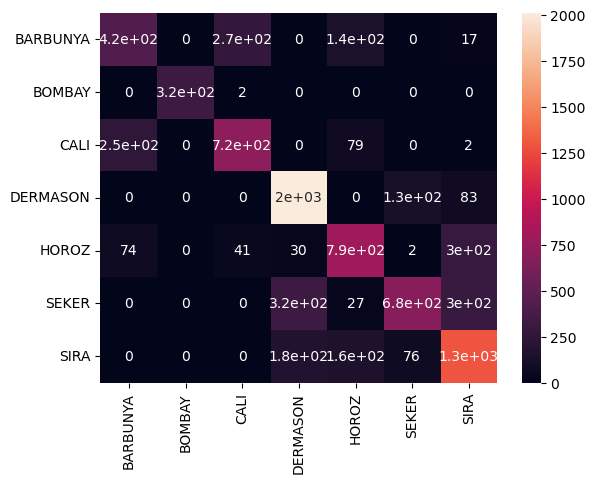

Accuracy ratio: 1516/2178
Validation accuracy: 0.696051


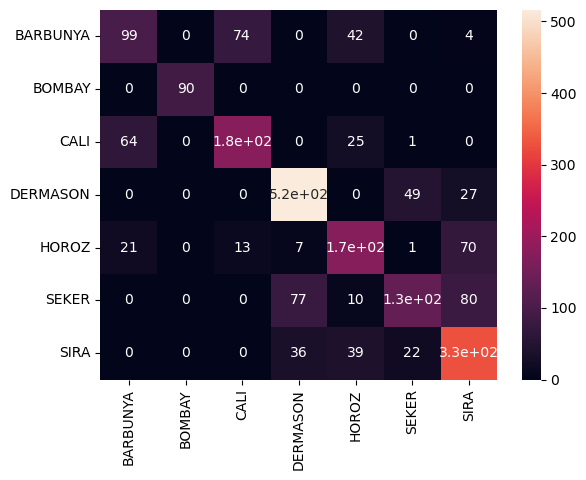

Accuracy ratio: 1909/2723
Test accuracy: 0.701065


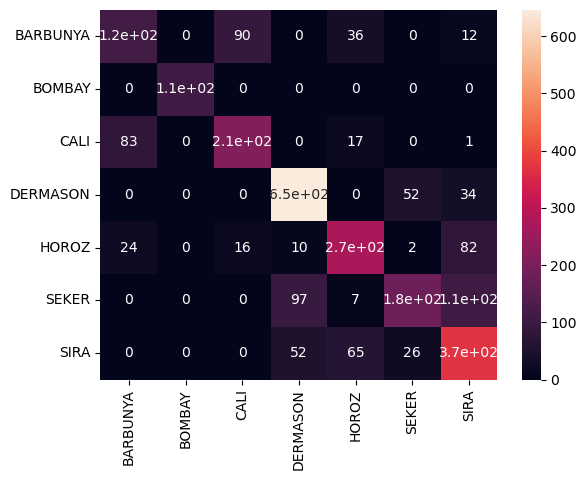

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
BARBUNYA,116,0,90,0,36,0,12
BOMBAY,0,108,0,0,0,0,0
CALI,83,0,213,0,17,0,1
DERMASON,0,0,0,646,0,52,34
HOROZ,24,0,16,10,272,2,82
SEKER,0,0,0,97,7,184,108
SIRA,0,0,0,52,65,26,370


In [25]:
class_names = {
        0: 'BARBUNYA',
        1: 'BOMBAY',
        2: 'CALI',
        3: 'DERMASON',
        4: 'HOROZ',
        5: 'SEKER',
        6: 'SIRA'
    }
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(bean.data.features.copy().to_numpy(), bean.data.targets_nums.copy())
knn = KNearestNeighbors(k=20, distance_measure=euclidean_distance) #<-- Here is where I changed the k number to conduct my tests
knn.fit(X_trn, y_trn)
y_trn_hat = knn.predict(X_trn)
trn_acc = accuracy(y=y_trn, y_hat=y_trn_hat)
print(f"Training accuracy: {trn_acc:.6f}")
plot_confusion_matrix(y_trn, y_trn_hat, class_names)
y_vld_hat = knn.predict(X_vld)
vld_acc = accuracy(y=y_vld, y_hat=y_vld_hat)
print(f"Validation accuracy: {vld_acc:.6f}")
plot_confusion_matrix(y_vld, y_vld_hat, class_names)
y_tst_hat = knn.predict(X_tst)
tst_acc = accuracy(y=y_tst, y_hat=y_tst_hat)
print(f"Test accuracy: {tst_acc:.6f}")
plot_confusion_matrix(y_tst, y_tst_hat, class_names)

Accuracy ratio: 7807/8710
Training accuracy: 0.896326


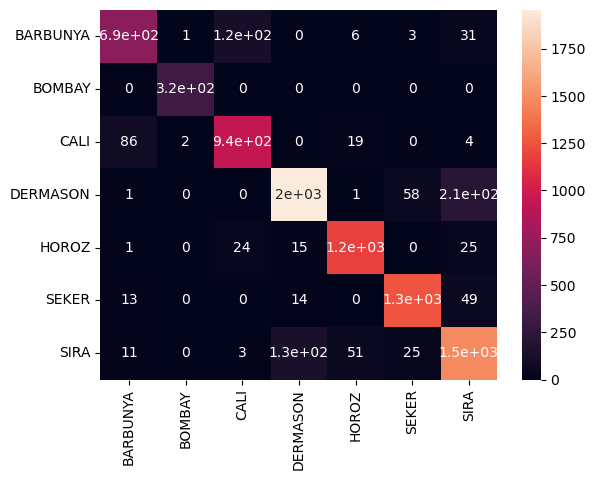

Accuracy ratio: 1957/2178
Validation accuracy: 0.898531


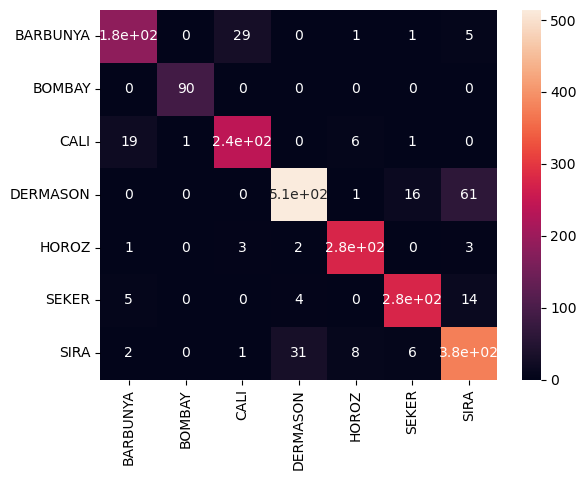

Accuracy ratio: 2443/2723
Testing accuracy: 0.897172


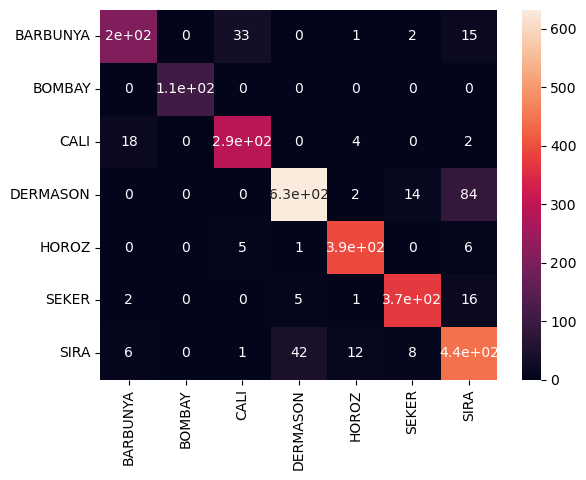

,BARBUNYA,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
BARBUNYA,203,0,33,0,1,2,15
BOMBAY,0,108,0,0,0,0,0
CALI,18,0,290,0,4,0,2
DERMASON,0,0,0,632,2,14,84
HOROZ,0,0,5,1,394,0,6
SEKER,2,0,0,5,1,372,16
SIRA,6,0,1,42,12,8,444


In [26]:
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data() #<-- Here is where I added the lists of features to drop in order to run my tests
gnb = GaussianNaiveBayes()
gnb.fit(X_trn, y_trn)
y_trn_pred = gnb.predict(X_trn)
trn_acc = accuracy(y=y_trn, y_hat=y_trn_pred)
print(f"Training accuracy: {accuracy_score(y_trn, y_trn_pred):f}")
plot_confusion_matrix(y_trn, y_trn_pred, class_names)
y_vld_pred = gnb.predict(X_vld)
vld_acc = accuracy(y=y_vld, y_hat=y_vld_pred)
print(f"Validation accuracy: {accuracy_score(y_vld, y_vld_pred):f}")
plot_confusion_matrix(y_vld, y_vld_pred, class_names)
y_tst_pred = gnb.predict(X_tst)
tst_acc = accuracy(y=y_tst, y_hat=y_tst_pred)
print(f"Testing accuracy: {accuracy_score(y_tst, y_tst_pred):f}")
plot_confusion_matrix(y_tst, y_tst_pred, class_names)